# WhatsApp Sport tournament Stats

In [487]:
import os
import re
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [488]:
file_path = "C:/Users/david/Documents/Projects/WhatsApp Bot/WhatsAppBot/data/Chat de WhatsApp con Family Deporte.txt"
participants = {
    'David',
    'Adri',
    'Adrian',
    'Carmen',
    'Diego',
    'Ivette',
    'Patricio',
    'Ramón',
    'Sam',
    'Santiago',
    'Vannesa'
}
dir_indicator = "family_deporte"

In [489]:
# file_path = "C:/Users/david/Documents/Projects/WhatsApp Bot/WhatsAppBot/data/Chat de WhatsApp con Torneo Saiyajin.txt"
# participants = {
#     'David',
#     'Alejandro',
#     'Andrea',
#     'Chirino',
#     'Emiliano',
#     'Fernando',
#     'Armando',
#     'Octavio',
#     'Ricardo',
#     'Uriel',
#     'Sara',
#     'Tupac',
#     'Mathilde',
#     'Capucine',
#     'Tania',
# }
# dir_indicator = "sport_avec_potes"

In [490]:
week = 1

## Raw Data

In [491]:
# read txt file
with open(file_path, 'r', encoding='utf-8') as file:
    raw_data = file.readlines()


from pprint import pprint
pprint(raw_data)

['21/7/2025, 21:54 - Los mensajes y las llamadas están cifrados de extremo a '
 'extremo. Solo las personas en este chat pueden leerlos, escucharlos o '
 'compartirlos. Obtén más información.\n',
 '21/7/2025, 21:54 - Creaste este grupo\n',
 '21/7/2025, 21:55 - Añadiste a 🍇🍉 Adri 🥗🥩.\n',
 '21/7/2025, 21:55 - David De la Rocha: Reglas: \n',
 '- Las actividades físicas como gym, caminata, natación, bicicleta, zumba, '
 'etc, cuentan para sumar un punto\n',
 '- Cada quien tiene un máximo de 4 puntos por semana, y un punto por día \n',
 '- Al final del año, las 3 personas con menos puntos invitaran a cenar al '
 'resto\n',
 '- Se recomienda mandar una foto o evidencia de la actividad efectuada\n',
 '- A quien se le descubra haciendo trampa se le restarán 3 puntos <Se editó '
 'este mensaje.>\n',
 '21/7/2025, 21:56 - David De la Rocha: David: 0\n',
 'Adri: 0\n',
 'Adrian: 0\n',
 'Carmen: 0\n',
 'Diego: 0\n',
 'Ivette: 0\n',
 'Patricio: 0\n',
 'Ramón: 0\n',
 'Sam: 0\n',
 'Santiago: 0\n',
 'Va

## Data Extraction

In [492]:
results = []
current_entry = None
participants_set = set(participants)  # use set for faster lookup

# patrón para inicio de mensaje de WhatsApp
start_pattern = re.compile(r"^(\d{1,2}/\d{1,2}/\d{4}), (\d{1,2}:\d{2}) - (.*?): (.*)")
points_pattern = re.compile(r"^(.+?)\s*:\s*(\d+)$")

for line in raw_data:
    line = line.replace('\xa0', ' ').strip()

    start_match = start_pattern.match(line)

    if start_match:
        # nuevo mensaje: guarda fecha, hora y autor
        date_str, time_str, author, content = start_match.groups()
        timestamp = datetime.strptime(f"{date_str} {time_str}", "%d/%m/%Y %H:%M")

        current_entry = {
            "timestamp": timestamp,
            "author": author,
            "points": {}
        }
        results.append(current_entry)

        # si el contenido también es un puntaje, procesar aquí
        inline_points = points_pattern.match(content)
        if inline_points:
            name, pts = inline_points.groups()
            if name in participants_set:
                current_entry["points"][name] = int(pts)

    elif current_entry:
        # posibles líneas con puntos adicionales
        point_match = points_pattern.match(line)
        if point_match:
            name, pts = point_match.groups()
            if name in participants_set:
                current_entry["points"][name] = int(pts)


In [493]:
results

[{'timestamp': datetime.datetime(2025, 7, 21, 21, 55),
  'author': 'David De la Rocha',
  'points': {}},
 {'timestamp': datetime.datetime(2025, 7, 21, 21, 56),
  'author': 'David De la Rocha',
  'points': {'David': 0,
   'Adri': 0,
   'Adrian': 0,
   'Carmen': 0,
   'Diego': 0,
   'Ivette': 0,
   'Patricio': 0,
   'Ramón': 0,
   'Sam': 0,
   'Santiago': 0}},
 {'timestamp': datetime.datetime(2025, 7, 21, 21, 56),
  'author': '🍇🍉 Adri 🥗🥩',
  'points': {}},
 {'timestamp': datetime.datetime(2025, 7, 21, 22, 1),
  'author': 'David De la Rocha',
  'points': {}},
 {'timestamp': datetime.datetime(2025, 7, 22, 2, 22),
  'author': 'Vannesa García',
  'points': {}},
 {'timestamp': datetime.datetime(2025, 7, 22, 2, 22),
  'author': 'Vannesa García',
  'points': {}},
 {'timestamp': datetime.datetime(2025, 7, 22, 2, 22),
  'author': 'Santiago Avendaño',
  'points': {}},
 {'timestamp': datetime.datetime(2025, 7, 22, 2, 22),
  'author': 'Vannesa García',
  'points': {}},
 {'timestamp': datetime.dateti

## Format Data

In [494]:
# create a list of rows, each row is a dict with timestamp + points
rows = []

for entry in results:
    row = {"timestamp": entry["timestamp"]}
    row.update(entry["points"])
    rows.append(row)

# create the dataframe
df = pd.DataFrame(rows)

# optionally, sort by timestamp
df = df.sort_values("timestamp").reset_index(drop=True)

# clean empty rows
df = df.dropna(subset=df.columns[1:], how='all')

# convert to int
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# show the dataframe
print(df)


              timestamp  David  Adri  Adrian  Carmen  Diego  Ivette  Patricio  \
1   2025-07-21 21:56:00      0     0       0       0      0       0         0   
20  2025-07-22 13:55:00      1     0       0       0      0       0         0   
26  2025-07-22 17:25:00      1     0       0       0      0       0         0   
30  2025-07-22 17:29:00      1     0       0       0      0       0         0   
32  2025-07-22 20:18:00      1     1       0       0      0       0         0   
35  2025-07-22 21:30:00      1     1       0       0      0       0         0   
37  2025-07-22 21:39:00      1     1       0       0      0       0         0   
38  2025-07-22 22:19:00      1     1       0       0      0       0         1   
40  2025-07-23 01:22:00      1     1       0       0      0       0         1   
54  2025-07-23 04:07:00      1     1       0       0      0       1         1   
55  2025-07-23 10:02:00      2     1       0       0      0       1         1   
56  2025-07-23 19:42:00     

In [495]:
df[["timestamp", "Sara"]]

KeyError: "['Sara'] not in index"

## Points by day

In [ ]:
# extract the date (year-month-day) from timestamp
df["date"] = df["timestamp"].dt.date

# group by date and get max points per participant
daily_points = df.groupby("date").max(numeric_only=True).reset_index()

# create full date range from min to max date
full_range = pd.date_range(start=daily_points["date"].min(), end=daily_points["date"].max(), freq="D")

# reindex the dataframe to include all days
daily_points = daily_points.set_index("date").reindex(full_range).rename_axis("date").reset_index()

# fill missing dates with previous values
daily_points = daily_points.fillna(method='ffill')

# add day name (e.g., Monday, Tuesday)
daily_points["day"] = pd.to_datetime(daily_points["date"]).dt.day_name()

# reorder columns to have day first (optional)
cols = ["date", "day"] + [col for col in daily_points.columns if col not in ["date", "day"]]
daily_points = daily_points[cols]

# show the daily summary
print(daily_points)


         date        day  David  Alejandro  Andrea  Chirino  Emiliano  \
0  2025-07-14     Monday      0          1       0        1         0   
1  2025-07-15    Tuesday      1          1       1        1         1   
2  2025-07-16  Wednesday      2          2       2        2         2   
3  2025-07-17   Thursday      3          3       3        3         3   
4  2025-07-18     Friday      3          4       3        4         3   
5  2025-07-19   Saturday      4          5       4        4         4   
6  2025-07-20     Sunday      4          5       4        4         5   
7  2025-07-21     Monday      4          6       5        5         6   
8  2025-07-22    Tuesday      5          6       6        5         7   
9  2025-07-23  Wednesday      6          7       6        5         7   
10 2025-07-24   Thursday      6          7       6        5         8   
11 2025-07-25     Friday      6          7       6        5         8   
12 2025-07-26   Saturday      7          8       7 

C:\Users\david\AppData\Local\Temp\ipykernel_16492\1683877435.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_points = daily_points.fillna(method='ffill')


## Points by week

In [ ]:
# ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# group by week starting on Monday and get max points per participant per week
weekly_points = (
    df.set_index("timestamp")
      .groupby(pd.Grouper(freq="W-SUN"))
      .max(numeric_only=True)
      .reset_index()
)

# rename timestamp to week_start
weekly_points.rename(columns={"timestamp": "week_end"}, inplace=True)

# add a week number column starting at 1
weekly_points["week_number"] = range(1, len(weekly_points) + 1)

# reorder columns to have week_number first (optional)
cols = ["week_number", "week_end"] + [col for col in weekly_points.columns if col not in ["week_number", "week_end"]]
weekly_points = weekly_points[cols]

print(weekly_points)

   week_number   week_end  David  Alejandro  Andrea  Chirino  Emiliano  \
0            1 2025-07-20      4          5       4        4         5   
1            2 2025-07-27      7          8       7        5         9   
2            3 2025-08-03      9          9       8        5        10   

   Fernando  Armando  Octavio  Ricardo  Uriel  Sara  Tupac  Mathilde  \
0         2        5        4        5      4     4      3         2   
1         5       10        6        7      9     9      6         5   
2         5       10        7        7     10    10      7         5   

   Capucine  Tania  
0         2      0  
1         5      2  
2         6      3  


## Export Stats

In [ ]:
# create week directory if it doesn't exist
week_dir = f"data/week_{week}/{dir_indicator}"
if not os.path.exists(week_dir):
    os.makedirs(week_dir)

### Total points for current week

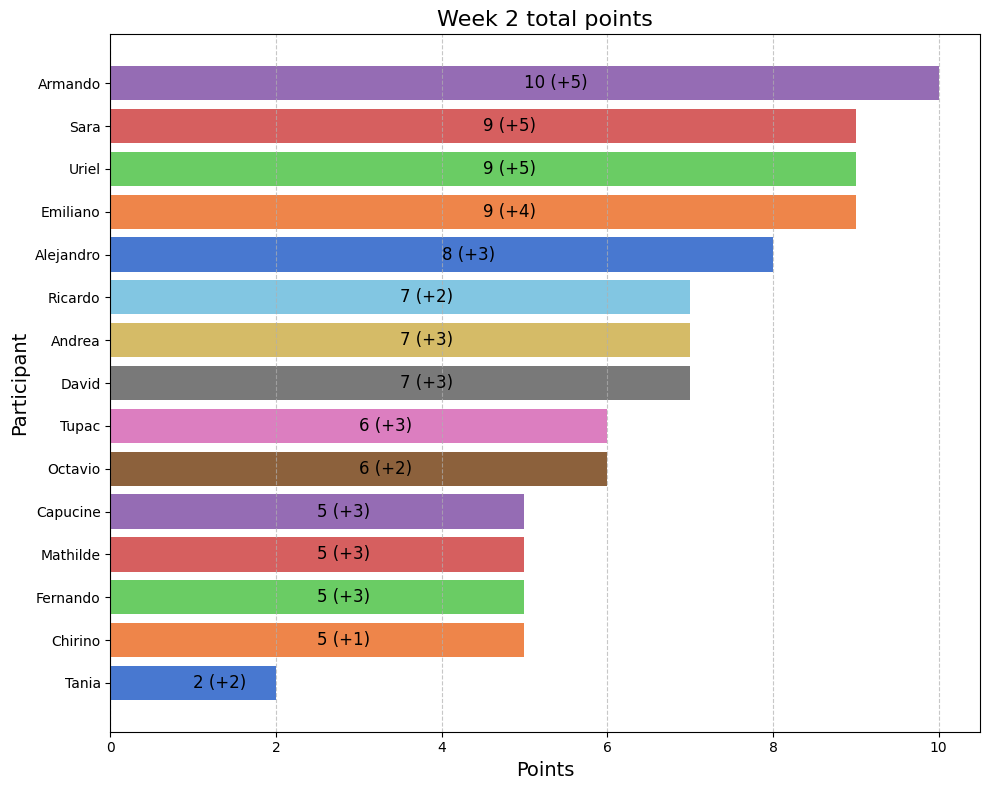

In [ ]:
# get max points per participant and sort ascending for horizontal bar plot
current_week_data = weekly_points[weekly_points.week_number == week].drop(columns=["week_end", "week_number"])
max_points = current_week_data.max()
max_points_sorted = max_points.sort_values(ascending=True)

# compute delta from previous week if available
if week > 1:
    prev_week_data = weekly_points[weekly_points.week_number == (week - 1)].drop(columns=["week_end", "week_number"])
    prev_points = prev_week_data.max()
    deltas = max_points - prev_points
else:
    deltas = max_points.copy()
    deltas[:] = 0  # no delta for the first week

# use a softer color palette
palette = sns.color_palette("muted", len(max_points_sorted))

plt.figure(figsize=(10, 8))
bars = plt.barh(max_points_sorted.index, max_points_sorted.values, color=palette)

# add label to each bar: "total (+delta)"
for i, bar in enumerate(bars):
    name = max_points_sorted.index[i]
    total = bar.get_width()
    delta = deltas[name]
    
    # format label with delta if not first week
    if week > 1:
        label = f"{int(total)} (+{int(delta)})"
    else:
        label = f"{int(total)}"
    
    plt.text(
        total / 2,
        bar.get_y() + bar.get_height() / 2,
        label,
        va='center',
        ha='left',
        fontsize=12,
        color='black'
    )

plt.title(f"Week {week} total points", fontsize=16)
plt.xlabel("Points", fontsize=14)
plt.ylabel("Participant", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()

# export to image
plt.savefig(f"{week_dir}/week_{week}_total_points.png")

plt.show()
plt.close()

### Points per Day for week X

In [ ]:
# get the end date of the selected week
week_row = weekly_points[weekly_points["week_number"] == week]
if week_row.empty:
    print(f"Week {week} not found.")
else:
    week_end = pd.to_datetime(week_row["week_end"].values[0])
    week_start = week_end - pd.Timedelta(days=6)

    # filter daily data for the selected week
    mask = (pd.to_datetime(daily_points["date"]) >= week_start) & (pd.to_datetime(daily_points["date"]) <= week_end)
    week_data = daily_points.loc[mask].copy()

    if week_data.empty:
        print(f"No daily data found for week {week}.")
    else:
        # add a column with the name of the day
        week_data["day"] = pd.to_datetime(week_data["date"]).dt.day_name()

        # reorder columns: date, day, participants
        cols = ["date", "day"] + [c for c in week_data.columns if c not in ["date", "day"]]
        week_data = week_data[cols]

        # convert to int
        for col in week_data.columns[2:]:
            week_data[col] = pd.to_numeric(week_data[col], errors='coerce').fillna(0).astype(int)

        # remove hours from date
        week_data["date"] = pd.to_datetime(week_data["date"]).dt.date

        # print table to console
        print(week_data)

        # export table as image
        plt.figure(figsize=(len(participants) + 4, 0.5 + len(week_data) * 0.4))
        plt.axis('off')
        table = plt.table(
            cellText=week_data.values,
            colLabels=week_data.columns,
            cellLoc='center',
            loc='center'
        )
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)

        # save image
        output_path = f"{week_dir}/week_{week}_daily_table.png"
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()
        print(f"Saved table to {output_path}")


          date        day  David  Alejandro  Andrea  Chirino  Emiliano  \
7   2025-07-21     Monday      4          6       5        5         6   
8   2025-07-22    Tuesday      5          6       6        5         7   
9   2025-07-23  Wednesday      6          7       6        5         7   
10  2025-07-24   Thursday      6          7       6        5         8   
11  2025-07-25     Friday      6          7       6        5         8   
12  2025-07-26   Saturday      7          8       7        5         8   
13  2025-07-27     Sunday      7          8       7        5         9   

    Fernando  Armando  Octavio  Ricardo  Uriel  Sara  Tupac  Mathilde  \
7          3        5        4        5      4     4      4         2   
8          4        6        4        5      4     4      4         3   
9          5        7        6        6      5     5      4         3   
10         5        8        6        6      6     6      4         4   
11         5        9        0        7   